# Data Entry

In [903]:
# Libraries
import pandas as pd
import inflection

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from streamlit_folium import folium_static
import folium
from folium.plugins import MarkerCluster

In [904]:
# Dataset
df_path = "C:/Users/victo/comunidade_ds/repos/modulo_03_-_analise_de_dados_em_python/projeto_final/"
df_raw = pd.read_csv(df_path + "zomato.csv")

df = df_raw.copy()

# Cleaning DataFrame

In [905]:
# Variable types are already appropriate.
# Check which columns have NaN values.
for col in df:
    if df[col].isnull().any() == True: 
        print(col)

Cuisines


In [906]:
def clean_code(df):
    # Dropping duplicates.
    df.drop_duplicates(inplace=True)


    # Deleting rows with NaN values
    for col in df:
        df = df.loc[ (df[col].isnull() == False) , :]


    # Making new columns to better describe the informations we have.
    #

    # Rename the columns to something_like_this.
    def rename_columns(dataframe):
        df = dataframe.copy()

        title = lambda x: inflection.titleize(x)
        snakecase = lambda x: inflection.underscore(x)
        spaces = lambda x: x.replace(" ", "")

        cols_old = list(df.columns)
        cols_old = list(map(title, cols_old))
        cols_old = list(map(spaces, cols_old))
        cols_new = list(map(snakecase, cols_old))

        df.columns = cols_new
        return df

    df = rename_columns(df).copy()



    # Defining countries codes by their names.
    countries = {
                1: "India",
                14: "Australia",
                30: "Brazil",
                37: "Canada",
                94: "Indonesia",
                148: "New Zeland",
                162: "Philippines",
                166: "Qatar",
                184: "Singapure",
                189: "South Africa",
                191: "Sri Lanka",
                208: "Turkey",
                214: "United Arab Emirates",
                215: "England",
                216: "United States of America",
                }

    def country_name(country_id):
        return countries[country_id]

    df["country"] = df["country_code"].apply(country_name)



    # Defining price ranges with a more intuitive description.
    def create_price_type(price_range):
        if price_range == 1:
            return "cheap"
        elif price_range == 2:
            return "normal"
        elif price_range == 3:
            return "expensive"
        else:
            return "gourmet"

    df["price_type"] = df["price_range"].apply(create_price_type)



    # Transforming the hex code to color name.
    colors = {
            "3F7E00": "darkgreen",
            "5BA829": "green",
            "9ACD32": "lightgreen",
            "CDD614": "lemon",
            "FFBA00": "yellow",
            "CBCBC8": "gray",
            "FF7800": "orange",
            }

    def color_name(hex_code):
        return colors[hex_code]

    df["rating_color"] = df["rating_color"].apply(color_name)



    # Translating the rating text.
    rating_text = {
                    "darkgreen": "Excellent",
                    "green": "Very Good",
                    "lightgreen": "Good",
                    "lemon": "Average",
                    "yellow": "Average",
                    "gray": "Not rated",
                    "orange": "Poor",
                    }

    def rating_translation(rating_color):
        return rating_text[rating_color]

    df["rating_text"] = df["rating_color"].apply(rating_translation)



    # Also use only one type of cuisine for the restaurants.
    df["cuisines"] = df.loc[:, "cuisines"].apply(lambda x: x.split(",")[0])



    # Convert every currency to Dollar and delete absurd values (over $ 10.000 a meal)
    currency_convertion_to_dollar = {
                                    'Botswana Pula(P)': 0.076,
                                    'Brazilian Real(R$)': 0.21,
                                    'Dollar($)': 1.0,
                                    'Emirati Diram(AED)': 0.27,
                                    'Indian Rupees(Rs.)': 0.012,
                                    'Indonesian Rupiah(IDR)': 0.000067,
                                    'NewZealand($)': 0.64,
                                    'Pounds(£)': 1.31,
                                    'Qatari Rial(QR)': 0.27,
                                    'Rand(R)': 0.055,
                                    'Sri Lankan Rupee(LKR)': 0.0031,
                                    'Turkish Lira(TL)': 0.038
                                    }

    def price_in_dollar(original_currency, original_price):
        return currency_convertion_to_dollar[original_currency] * original_price

    df["dollar_average_cost_for_two"] = df.apply(lambda x: price_in_dollar(x["currency"], x["average_cost_for_two"]), axis=1)
    df = df.loc[ (df["dollar_average_cost_for_two"] < 1000) ,:]


    # Reset index after cleaning everything.
    return df.reset_index(drop=True)

In [907]:
df = clean_code(df)

# Zomato Marketplace: KPIs and Business Insights

Zomato is the connection between restaurants spread around the world and those ready for a meal. The following analysis will help us identify the best way improve our services and grow together.

In [908]:
# HELPER FUNCTIONS ----------------------------------------------------------------------------------------------------
def adjust_df(df):
    # Index starting from 1
    df.index = df.index + 1
    
    # Centered format
    df = df.style.set_table_styles( [ {'selector': 'thead th', 'props': [('text-align', 'center')] } ] )
    df = df.set_properties(**{'text-align': 'center'})
    
    return df


# ----------------------------------------------------------------------------------------------------------------------

## 1 Overview

In [909]:
df.columns

Index(['restaurant_id', 'restaurant_name', 'country_code', 'city', 'address',
       'locality', 'locality_verbose', 'longitude', 'latitude', 'cuisines',
       'average_cost_for_two', 'currency', 'has_table_booking',
       'has_online_delivery', 'is_delivering_now', 'switch_to_order_menu',
       'price_range', 'aggregate_rating', 'rating_color', 'rating_text',
       'votes', 'country', 'price_type', 'dollar_average_cost_for_two'],
      dtype='object')

In [910]:
locations = df[['latitude','longitude']].values.tolist()
popups = df[['city','restaurant_name','aggregate_rating']].values.tolist()


mapa = folium.Map()

MarkerCluster(locations=locations, popups=popups).add_to(mapa)

folium_static(mapa, width=1024, height=600)

DeltaGenerator()

#### 1.1 Number of Unique registered Restaurants in the Zomato Marketplace.

In [911]:
#SA Show number of unique restaurants in the dataframe.
#PE Count the amount of different "restaurant_id"s using len() and .unique().
num_of_unique_restaurants = len( df["restaurant_id"].unique() )
print(num_of_unique_restaurants)

6928


#### 1.2 Number of Unique registered Countries.

In [912]:
#SA Show number of unique countries in the dataframe.
#PE Count the amount of different "country"s using len() and .unique().
num_of_unique_countries = len( df["country"].unique() )
print(num_of_unique_countries)

15


#### 1.3 Number of Unique registered Cities.

In [913]:
#SA Show number of unique cities in the dataframe.
#PE Count the amount of different "city"s using len() and .unique().
num_of_unique_cities = len( df["city"].unique() )
print(num_of_unique_cities)

125


#### 1.4 Total of Ratings and Average Rating in the platform.

In [914]:
#SA Show total number of ratings in the dataframe.
#PE Just sum all the "votes".
num_of_unique_ratings = df["votes"].sum()
print(num_of_unique_ratings)

4194330


In [915]:
#SA Show average value of ratings in the dataframe.
#PE Just take the mean of all the "aggregate_rating"s.
average_rating = df["aggregate_rating"].mean()
print("{:.2f}".format(average_rating))

4.13


#### 1.5 Number of Cuisines available.

In [916]:
#SA Show number of unique cuisines in the dataframe.
#PE Count the amount of different "cuisines" using len() and .unique().
num_of_unique_cuisines = len( df["cuisines"].unique() )
print(num_of_unique_cuisines)

165


## 2 Countries Vision

#### 2.1 Country with most Registered Cities.

In [917]:
def countries_reg_cities_df():
    # Countries with most unique cities
    df_cities_by_country = ( df.loc[ : , ["country", "city"] ].groupby( ["country"] ).nunique()
                                                              .sort_values("city", ascending=False)
                                                              .reset_index() )
    
    reg_cities = df_cities_by_country.loc[ :4 , ["country", "city"] ]
    
    
    return adjust_df(reg_cities) 
    
    
countries_reg_cities_df()

,country,city
1,India,49
2,United States of America,22
3,Philippines,12
4,South Africa,12
5,England,5


#### ~~2.2 Country with most Registered Restaurants.~~

In [918]:
#SA Name of country with most unique restaurants.

#PE Group restaurants by country and count unique restaurants using .groupby() and .nunique(). Order countries by number of restaurants with 
#PE .sort_values() (descending) and show the first country.
df_restaurants_by_country = ( df.loc[ : , ["country", "restaurant_id"] ].groupby( ["country"] ).nunique()
                                                                        .sort_values("restaurant_id", ascending=False)
                                                                        .reset_index() )

df_restaurants_by_country.loc[ : , ["country", "restaurant_id"] ]

,country,restaurant_id
0,India,3111
1,United States of America,1374
2,England,400
3,South Africa,346
4,United Arab Emirates,300
5,Brazil,240
6,New Zeland,239
7,Canada,180
8,Australia,179
9,Turkey,159


#### ~~2.3 Country with most Registered Restaurants that has the Price of Gourmet (maximum average Price Range: 4).~~

In [919]:
#SA Name of country with most unique restaurants with price range 4.
#PE Create auxiliary dataframe with only restaurants with price_range == 4.
#PE Group restaurants by country and count unique restaurants using .groupby() and .nunique(). Order countries by number of restaurants with 
#PE .sort_values() (descending) and show the first country.
df_price_range_4 = df.loc[ ( df.loc[ : , "price_range" ] == 4 ) , : ]
df_price4_country = ( df_price_range_4.loc[ : , ["country", "restaurant_id"] ].groupby( ["country"] ).nunique()
                                                                              .sort_values("restaurant_id", ascending=False)
                                                                              .reset_index() )

df_price4_country.loc[ 0 , "country" ]

'United States of America'

#### 2.4 Country with most Cuisine types.

In [920]:
def countries_cuisines_df():
    # Countries with most unique cuisines
    df_cuisines_by_country = ( df.loc[ : , ["country", "cuisines"] ].groupby( ["country"] ).nunique()
                                                                    .sort_values("cuisines", ascending=False)
                                                                    .reset_index() )

    df_cuisines_by_country = df_cuisines_by_country.loc[ 0:4 , ["country", "cuisines"] ]

    return adjust_df(df_cuisines_by_country)

countries_cuisines_df()

,country,cuisines
1,India,77
2,United States of America,74
3,England,52
4,United Arab Emirates,46
5,Australia,43


#### ~~2.5 Country with biggest absolute amount of Ratings.~~

In [921]:
#SA Name of country with most ratings.
#PE Group votes by country and count votes using .groupby() and .votes(). Order countries by number of votes with 
#PE .sort_values() (descending) and show the first country.
df_cities_by_country = ( df.loc[ : , ["country", "votes"] ].groupby( ["country"] ).sum()
                                                           .sort_values("votes", ascending=False)
                                                           .reset_index() )

df_cities_by_country.loc[ 0 , "country" ]

'India'

#### 2.6 Country with most Ratings per Restaurant

In [922]:
def countries_ratings_per_restaurant_df():
    # Most ratings per restaurant

    # Group votes by country and count votes
    df_num_votes_by_country = ( df.loc[ : , ["country", "votes"] ].groupby( ["country"] ).sum()
                                                                  .sort_values("votes", ascending=False)
                                                                  .reset_index() )


    # Group restaurants by country and count unique restaurants
    df_num_of_restaurants_by_country = ( df.loc[ : , ["country", "restaurant_id"] ].groupby( ["country"] ).nunique()
                                                                                   .sort_values("restaurant_id", ascending=False)
                                                                                   .reset_index() )

    # Merge df_num_votes_by_country and df_num_of_restaurants_by_country 
    # Create a new column with ratings_per_restaurant
    df_rate_ratings_by_country = pd.merge(df_num_votes_by_country, df_num_of_restaurants_by_country, how="inner")
    df_rate_ratings_by_country["ratings_per_restaurant"] = df_rate_ratings_by_country["votes"] / df_rate_ratings_by_country["restaurant_id"]
    df_rate_ratings_by_country["ratings_per_restaurant"] = df_rate_ratings_by_country["ratings_per_restaurant"]

    # Use only country and ratings_per_restaurant
    top_ratings_per_restaurant = df_rate_ratings_by_country.sort_values("ratings_per_restaurant", ascending=False).reset_index(drop=True)
    
    top_ratings_per_restaurant = top_ratings_per_restaurant.loc[ :4, ["country", "ratings_per_restaurant" ] ]
    top_ratings_per_restaurant['ratings_per_restaurant'] = top_ratings_per_restaurant['ratings_per_restaurant'].astype(int)

    
    return adjust_df(top_ratings_per_restaurant)

countries_ratings_per_restaurant_df()

,country,ratings_per_restaurant
1,Indonesia,1112
2,India,900
3,Australia,727
4,Turkey,630
5,Philippines,604


#### 2.7 Countries by Ratings.

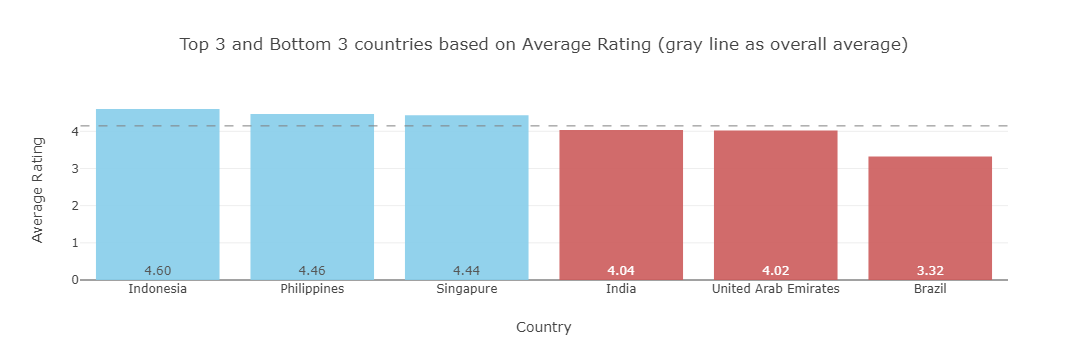

In [923]:
def country_ratings_avg_chart():
    # Best and Worst rated countries
    
    # Group by Ratings
    df_ratings = ( df.loc[ : , ["country", "aggregate_rating"] ].groupby( ["country"] ).mean()
                                                                .sort_values("aggregate_rating", ascending=False)
                                                                .reset_index() )

    top3_bottom3 = pd.concat( [df_ratings.head(3), df_ratings.tail(3)] )
    mean_rating = df_ratings['aggregate_rating'].mean()
    
    # Setting ratings colors
    top3_bottom3['color'] = ['skyblue' if country in top3_bottom3.head(3)['country'].values else 'indianred' for country in top3_bottom3['country']]
    
    # Defining chart data
    fig = go.Figure(data=[go.Bar( x=top3_bottom3['country'],
                                  y=top3_bottom3['aggregate_rating'],
                                  text=top3_bottom3['aggregate_rating'],
                                  marker_color=top3_bottom3['color'], opacity=0.9 )])

    fig.add_shape(type='line', x0=-0.5, x1=len(top3_bottom3)-0.5, y0=mean_rating, y1=mean_rating,
                  line=dict(color='gray', width=1, dash='dash'))

    fig.update_layout(title_text='Top 3 and Bottom 3 countries based on Average Rating (gray line as overall average)', title_x=0.5,
                      xaxis_title='Country', yaxis_title='Average Rating')

    fig.update_traces(textposition='inside', texttemplate='%{text:.2f}', textfont=dict(size=12), hoverinfo='text+y', insidetextanchor='start')

    return fig

country_ratings_avg_chart()

#### ~~2.8 Country with worst Ratings.~~

In [924]:
#SA Name of country with worst ratings.
#PE Group votes by country and count votes using .groupby() and .votes(). Order countries by number of votes with 
#PE .sort_values() (ascending) and show the first country.
df_ratings = ( df.loc[ : , ["country", "aggregate_rating"] ].groupby( ["country"] ).mean()
                                                            .sort_values("aggregate_rating", ascending=False)
                                                            .reset_index() )

top3_bottom3 = pd.concat( [df_ratings.head(3), df_ratings.tail(3)] )
top3_bottom3

,country,aggregate_rating
0,Indonesia,4.601250
1,Philippines,4.463750
2,Singapure,4.435000
12,India,4.037126
13,United Arab Emirates,4.023667
14,Brazil,3.321667


#### ~~2.9 Country with most absolute amount Restaurants with Delivery option.~~

In [925]:
#SA Name of country with most restaurants with delivery option.
#PE Create auxiliary dataframe with only restaurants with delivery option.
#PE Group restaurants by country and count unique restaurants using .groupby() and .nunique(). Order countries by number of restaurants with 
#PE .sort_values() (descending) and show the first country.
df_delivery_available = df.loc[ ( df.loc[ : , "is_delivering_now" ] == 1 ) , : ]
df_delivery_options_by_country = ( df_delivery_available.loc[ : , ["country", "restaurant_id"] ].groupby( ["country"] ).nunique()
                                                                                                .sort_values("restaurant_id", ascending=False)
                                                                                                .reset_index() )

df_delivery_options_by_country.loc[ 0 , "country" ]

'India'

#### 2.10 Country with Delivery presence.

In [926]:
def countries_delivery_presence_df():
    #SA Name of country with best frequency of delivery option.

    # Create a df_num_deliverers with only delivering restaurants.
    df_num_deliverers = df.loc[ (df.loc[ : , "is_delivering_now" ] == 1) , : ]

    # Group restaurants by country and count unique restaurants delivering
    df_num_of_restaurants_by_country = ( df.loc[ : , ["country", "restaurant_id"] ].groupby( ["country"] ).nunique()
                                                                                   .sort_values("restaurant_id", ascending=False)
                                                                                   .reset_index() )
    
    df_num_of_restaurants_by_country.rename(columns = {'restaurant_id':'total_restaurants'}, inplace = True)

    # Group restaurants by country and count them all
    df_num_deliv_by_country = ( df_num_deliverers.loc[ : , ["country", "restaurant_id"] ].groupby( ["country"] ).count()
                                                                                         .sort_values("restaurant_id", ascending=False)
                                                                                         .reset_index() )
    df_num_deliv_by_country.rename(columns = {'restaurant_id':'delivery_options'}, inplace = True)

    # Merge df_num_deliv_by_country and df_num_of_restaurants_by_country. 
    # Create a new column with delivery_presence =  delivery_options / total_restaurants
    df_freq_deliv_by_country = pd.merge(df_num_deliv_by_country, df_num_of_restaurants_by_country, on="country", how="inner")
    df_freq_deliv_by_country["delivery_presence"] = (df_freq_deliv_by_country["delivery_options"] / df_freq_deliv_by_country["total_restaurants"])
    df_freq_deliv_by_country['delivery_presence'] = df_freq_deliv_by_country['delivery_presence'].apply(lambda x: f'{x:.2%}')

    df_freq_deliv_by_country = df_freq_deliv_by_country[['country', 'total_restaurants', 'delivery_options', 'delivery_presence']]

    
    return adjust_df(df_freq_deliv_by_country)

countries_delivery_presence_df()

,country,total_restaurants,delivery_options,delivery_presence
1,India,3111,1150,36.97%
2,United Arab Emirates,300,52,17.33%
3,Philippines,80,7,8.75%
4,Qatar,80,3,3.75%


#### ~~2.11 Country with most absolute amount Restaurants with Reservation option.~~

In [927]:
#SA Name of country with most restaurants with reservation option.
#PE Create auxiliary dataframe with only restaurants with reservation option.
#PE Group restaurants by country and count unique restaurants using .groupby() and .nunique(). Order countries by number of restaurants with 
#PE .sort_values() (descending) and show the first country.
df_reservation_available = df.loc[ ( df.loc[ : , "has_table_booking" ] == 1 ) , : ]
df_reservation_options_by_country = ( df_reservation_available.loc[ : , ["country", "restaurant_id"] ].groupby( ["country"] ).nunique()
                                                                                                .sort_values("restaurant_id", ascending=False)
                                                                                                .reset_index() )

df_reservation_options_by_country.loc[ 0 , "country" ]

'India'

#### ~~2.12 Country with greatest frequency of Restaurants with Reservation option.~~

In [928]:
#SA Name of country with best frequency of reservation option.
#PE Create a df_num_reservers with only reservation restaurants.
df_num_reservers = df.loc[ (df.loc[ : , "has_table_booking" ] == 1) , : ]

#PE Group retaurants by country and count them using .groupby() and .votes(). Order countries by number of restaurants with 
#PE .sort_values() (descending) and show the first country.
df_num_reserv_by_country = ( df_num_reservers.loc[ : , ["country", "restaurant_id"] ].groupby( ["country"] ).count()
                                                                                     .sort_values("restaurant_id", ascending=False)
                                                                                     .reset_index() )
df_num_reserv_by_country.rename(columns = {'restaurant_id':'restaurant_reserv'}, inplace = True)

# Create a df_num_of_restaurants_by_country.
#PE Group restaurants by country and count unique restaurants using .groupby() and .nunique(). Order countries by number of restaurants with 
#PE .sort_values() (descending) and show the first country.
df_num_of_restaurants_by_country = ( df.loc[ : , ["country", "restaurant_id"] ].groupby( ["country"] ).nunique()
                                                                               .sort_values("restaurant_id", ascending=False)
                                                                               .reset_index() )
df_num_of_restaurants_by_country.rename(columns = {'restaurant_id':'restaurant_amount'}, inplace = True)

#PE Merge df_num_reserv_by_country and df_num_of_restaurants_by_country. Create a new column with rate_ratings =  votes / restaurant_id. Sort values 
#PE by rate_ratings (descending) and select the top country.
df_freq_reserv_by_country = pd.merge(df_num_reserv_by_country, df_num_of_restaurants_by_country, on="country", how="inner")
df_freq_reserv_by_country["freq_reserv_restaurant"] = df_freq_reserv_by_country["restaurant_reserv"] / df_freq_reserv_by_country["restaurant_amount"]

df_freq_reserv_by_country.sort_values("freq_reserv_restaurant", ascending=False).reset_index(drop=True).loc[0, ["country"]]

country    Philippines
Name: 0, dtype: object

#### 2.13 Average Cost For Two in each Country.

In [929]:
def countries_avg_cost_chart():
    # Bar plot of average cost for two in dollars in each country
    df_cost_by_country = ( df.loc[ : , ["country", "dollar_average_cost_for_two"] ].groupby( ["country"] ).mean()
                                                                                   .sort_values("dollar_average_cost_for_two", ascending=False)
                                                                                   .reset_index() )

    # Plot
    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=df_cost_by_country['country'],
        y=df_cost_by_country['dollar_average_cost_for_two'],
        marker_color='skyblue' ))

    fig.update_layout(
        title='Average Cost for Two by Country',
        xaxis_title='Country',
        yaxis_title='Average Cost for Two (in dollars)', title_x=0.5,
        xaxis=dict(tickangle=45, tickmode='array'))

    return fig

countries_avg_cost_chart()

## 3 Cities Vision

#### 3.1 Restaurant population per city

In [930]:
def cities_restaurant_pop_chart():
    # Barplot of amount of cities with certain restaurant populations
    df_restaurants_by_city = ( df.loc[ : , ["city", "restaurant_id"] ].groupby( ["city"] ).nunique()
                                                                      .sort_values("restaurant_id", ascending=False)
                                                                      .reset_index() )

    df_restaurants_by_city.columns = ["city", "number_of_restaurants"]


    cat = ['1-20', '21-40', '41-60', '61+']

    df_restaurants_by_city['number_of_restaurants'] = df_restaurants_by_city['number_of_restaurants'].apply( lambda x: cat[0] if x<=20 else 
                                                                                                                       cat[1] if ( (x>20) & (x<=40) ) else
                                                                                                                       cat[2] if ( (x>40) & (x<=60) ) else
                                                                                                                       cat[3] )

    df_restaurants_by_city = df_restaurants_by_city.loc[ :, [ 'number_of_restaurants', 'city' ] ].groupby('number_of_restaurants').count().reset_index()


    # Barplot
    fig = go.Figure()

    fig.add_trace(go.Bar(
                    x=df_restaurants_by_city['number_of_restaurants'],
                    y=df_restaurants_by_city['city'],
                    marker_color='indianred'))

    fig.update_layout(
        title='How many cities have restaurant population of 1-20, 21-40, 41-60 and 61+?',
        xaxis_title='Restaurant population rate',
        yaxis_title='Amount of Cities', title_x=0.5,
        xaxis=dict(tickangle=45, tickmode='array'))

    return fig

cities_restaurant_pop_chart()

#### 3.2 Cities with most restaurants with good (4.5+) rating.

In [931]:
def cities_most_excellent_restaurants_chart():
    #SA Barplot of cities with most 4.5+ rating restaurants.
    df_good_ratings = df.loc[ df["aggregate_rating"] >= 4.5, :]

    df_restaurants_by_city_and_good_rating = ( df_good_ratings.loc[ : , ["city", "restaurant_id"] ].groupby( ["city"] ).nunique()
                                                                                                   .sort_values("restaurant_id", ascending=False)
                                                                                                   .reset_index() )

    df_restaurants_by_city_and_good_rating.columns = ["city", "number_of_well_rated_restaurants"]
    top_10_cities = df_restaurants_by_city_and_good_rating.loc[ :9, : ]
    top_10_cities = pd.merge(top_10_cities, df[['city', 'country']], on='city', how='inner').drop_duplicates().reset_index(drop=True)

    
    # Bar chart
    fig = go.Figure(data=[go.Bar( x=top_10_cities['city'],
                                  y=top_10_cities['number_of_well_rated_restaurants'],
                                  hovertemplate=top_10_cities['country'],
                                  marker_color='skyblue' )])

    fig.update_layout(title_text='Cities with most restaurants rated as Excellent', title_x=0.5,
                      xaxis_title='City', yaxis_title='Amount of Excellent Restaurants')
    

    return fig

cities_most_excellent_restaurants_chart()

#### ~~3.3 Cities with most restaurants with bad (2.5-) rating.~~

In [932]:
#SA Table with cities with most 4+ rating restaurants.
#PE Select only restaurants with ratings 4+ using .loc, then group them by city .groupby.nunique() and sort cities by most to less of those restaurants with .sort_values.

df_bad_ratings = df.loc[ df["aggregate_rating"] <= 3 , :]

df_restaurants_by_city_and_bad_rating = ( df_bad_ratings.loc[ : , ["city", "aggregate_rating"] ].groupby( ["city"] ).nunique()
                                                                                                .sort_values("aggregate_rating", ascending=False)
                                                                                                .reset_index() )
df_restaurants_by_city_and_bad_rating.columns = ["city", "number_of_badly_rated_restaurants"]
df_restaurants_by_city_and_bad_rating.loc[ 0:9 , : ]

,city,number_of_badly_rated_restaurants
0,Rio de Janeiro,6
1,Brasília,5
2,Hamilton,5
3,Aurangabad,4
4,Durban,4
5,Allahabad,3
6,Ankara,3
7,Puducherry,3
8,Birmingham,3
9,Cape Town,3


#### 3.4 Most expensive cities

In [933]:
def cities_cost_df():
    #SA Table with most expensive cities for two people dishes.
    
    # Most expensive cities
    df_city_by_cost_for_two = ( df.loc[ : , ["city", "dollar_average_cost_for_two", "country"] ].groupby( ["city"] ).mean("dollar_average_cost_for_two")
                                                                                                         .sort_values("dollar_average_cost_for_two", ascending=False)
                                                                                                         .reset_index() )

    top_cities_df = df_city_by_cost_for_two.head(5)
    
    # Add cities' countries
    top_cities_df = pd.merge(top_cities_df, df[['city', 'country']], on='city', how='inner').drop_duplicates().reset_index(drop=True)


    # Add countries' cost rankings
    df_cost_by_country = ( df.loc[ : , ["country", "dollar_average_cost_for_two"] ].groupby( ["country"] ).mean()
                                                                                   .sort_values("dollar_average_cost_for_two", ascending=False)
                                                                                   .reset_index() )

    df_cost_by_country['country_cost_rank'] = df_cost_by_country['dollar_average_cost_for_two'].rank(ascending=False).astype(int)
    df_cost_by_country.drop( ['dollar_average_cost_for_two'], axis=1, inplace=True )

    cities_cost_rank_df = pd.merge(top_cities_df, df_cost_by_country, on='country', how='inner').drop_duplicates()
    
    return adjust_df(cities_cost_rank_df)

cities_cost_df()

,city,dollar_average_cost_for_two,country,country_cost_rank
1,Pasay City,304.000000,Philippines,2
2,Tagaytay City,101.333333,Philippines,2
3,Makati City,99.470588,Philippines,2
4,Singapore,141.437500,Singapure,1
5,New York City,101.500000,United States of America,5


#### 3.5 Cuisine Diversity

In [934]:
def cities_diversity_cuisine_chart():
    #SA Table with cities with most variety of cuisines.
    cities_cuisines_df = ( df.loc[ : , ["city", "cuisines"] ].groupby( ["city"] ).nunique()
                                                             .sort_values("cuisines", ascending=False)
                                                             .reset_index() )

    cities_cuisines_df['diversity'] = cities_cuisines_df['cuisines'].apply( lambda x: 'low' if x<10 else 'high' )


    # Labels and Values for Pie Chart
    diversity = [ 'High', 'Low' ]

    diversity_counts = []
    diversity_counts.append( cities_cuisines_df[ cities_cuisines_df['diversity'] == 'high' ].shape[0] )
    diversity_counts.append( cities_cuisines_df[ cities_cuisines_df['diversity'] == 'low' ].shape[0] )

    # Pie chart
    fig = go.Figure(data=[go.Pie( labels=diversity, 
                                  values=diversity_counts, 
                                  marker=dict(colors=['dodgerblue', 'indianred']) )])

    fig.update_layout( title_text='Most Cities have high or low diversity of Cuisines?', title_x=0.5 )

    return fig
    
cities_diversity_cuisine_chart()

#### ~~3.6 Cities with most restaurants that accept reservation.~~

In [935]:
#SA Table with cities with most restaurants with reservation option.
#PE Select only restaurants with reservation. Group cities by number of reservation using .groupby.nunique(). Sort cities by most to less options with .sort_values.

df_reservables = df.loc[ df["has_table_booking"] == 1, :]

df_city_by_reservation_option = ( df_reservables.loc[ : , ["city", "restaurant_id"] ].groupby( ["city"] ).nunique()
                                                                                     .sort_values("restaurant_id", ascending=False)
                                                                                     .reset_index() )

df_city_by_reservation_option.columns = ["city", "restaurants_with_reservation_option"]
df_city_by_reservation_option.loc[ 0:4 , : ]

,city,restaurants_with_reservation_option
0,Bangalore,42
1,Chennai,28
2,Pune,25
3,Mumbai,18
4,Brisbane,17


#### 3.7 Delivery presence

In [936]:
def cities_delicery_chart():
    #SA Pie chart delivery presence
    cities_delivery_option = ( df.loc[ : , ["city", "is_delivering_now"] ].groupby( ["city"] ).sum().reset_index() )

    
    # Labels and Values for Pie Chart
    cities_deliver_label = [ 'Yes', 'No' ]
    cities_deliver_values = [ cities_delivery_option[cities_delivery_option['is_delivering_now'] != 0].shape[0], 
                              cities_delivery_option[cities_delivery_option['is_delivering_now'] == 0].shape[0] ]

    # Pie chart
    fig = go.Figure(data=[go.Pie( labels=cities_deliver_label, 
                                  values=cities_deliver_values, 
                                  marker=dict(colors=['dodgerblue', 'indianred']) )])

    fig.update_layout( title_text='% of cities that have Delivery option', title_x=0.5 )

    return fig
    
cities_delicery_chart()

#### ~~3.8 Cities with most restaurants with online service.~~

In [937]:
#SA Table with cities with most restaurants with online service.
#PE Select only restaurants with online service. Group cities by number of restaurants with online service using .groupby.nunique(). Sort cities by most to less options with .sort_values.

df_online = df.loc[ df["has_online_delivery"] == 1, :]

df_city_by_online_option = ( df_online.loc[ : , ["city", "restaurant_id"] ].groupby( ["city"] ).nunique()
                                                                           .sort_values("restaurant_id", ascending=False)
                                                                           .reset_index() )

df_city_by_online_option.columns = ["city", "restaurants_with_delivery_option"]
df_city_by_online_option.loc[ : , : ].tail()

,city,restaurants_with_delivery_option
48,Makati City,3
49,Nasik,2
50,Gandhinagar,1
51,Ghaziabad,1
52,Zirakpur,1


## 4 Restaurants Vision

#### ~~4.1 Restaurants with most amount of ratings.~~

In [938]:
#SA Show table of top restaurants with most ratings.
#PE Order restaurants by "votes" with sort_values() and show only first rows and relevant columns using .loc[].

restaurants_with_most_ratings = df.sort_values("votes", ascending=False).reset_index(drop=True)
restaurants_with_most_ratings.loc[0:4, ["restaurant_id", 'cuisines', "restaurant_name", "country", "price_type", "aggregate_rating", "rating_text", "has_online_delivery", "votes"]]

,restaurant_id,cuisines,restaurant_name,country,price_type,aggregate_rating,rating_text,has_online_delivery,votes
0,90896,Biryani,Bawarchi,India,normal,4.5,Excellent,1,41333
1,58882,Continental,Byg Brewski Brewing Company,India,expensive,4.9,Excellent,1,17394
2,51705,Italian,Toit,India,expensive,4.7,Excellent,0,15270
3,51040,Cafe,Truffles,India,normal,4.7,Excellent,0,14984
4,308322,Continental,Hauz Khas Social,India,expensive,4.6,Excellent,1,13627


#### ~~4.2 Restaurants with best ratings~~

In [939]:
#SA Show table of restaurants with best ratings, in case of draw, rank by most votes.
#PE Find best rating of any restaurant. Select only restaurants with the best rating (.loc) and take the ones with most amount of ratings (.sort_values). Show table with valuable information.

best_rating = df["aggregate_rating"].max()
restaurants_with_best_ratings = df.loc[ df["aggregate_rating"] == best_rating , : ].sort_values("votes", ascending=False).reset_index(drop=True)

restaurants_with_best_ratings.loc[0:9, ["restaurant_id", "restaurant_name", 'cuisines', "country", 'city', "price_type", "aggregate_rating", "rating_text", "has_online_delivery", "votes"]]

,restaurant_id,restaurant_name,cuisines,country,city,price_type,aggregate_rating,rating_text,has_online_delivery,votes
0,58882,Byg Brewski Brewing Company,Continental,India,Bangalore,expensive,4.9,Excellent,1,17394
1,56618,AB's - Absolute Barbecues,European,India,Bangalore,expensive,4.9,Excellent,0,12443
2,70856,AB's - Absolute Barbecues,BBQ,India,Chennai,expensive,4.9,Excellent,0,9774
3,20842,Barbeque Nation,North Indian,India,Kolkata,expensive,4.9,Excellent,0,8271
4,18148977,AB's - Absolute Barbecues,European,India,Bangalore,expensive,4.9,Excellent,0,6877
5,18595414,Coal Barbecues,North Indian,India,Chennai,expensive,4.9,Excellent,0,5776
6,8913,Pirates of Grill,North Indian,India,Gurgaon,gourmet,4.9,Excellent,0,5760
7,18017612,Spice Kraft,Continental,India,Kolkata,expensive,4.9,Excellent,0,4935
8,18567253,Sushi Hiro,Sushi,Indonesia,Jakarta,gourmet,4.9,Excellent,0,4416
9,17242247,Café Du Monde,Coffee and Tea,United States of America,New Orleans,cheap,4.9,Excellent,0,4036


#### ~~4.3 Restaurants with most expensive dishes for two~~

In [940]:
#SA Show table of restaurants with most expensive dishes for two people.
#PE Order restaurants by "dollar_average_cost_for_two" (.sort_values) and show the first lines.

restaurants_by_cost_for_two = df.sort_values("dollar_average_cost_for_two", ascending=False).reset_index(drop=True)

restaurants_by_cost_for_two.loc[0:4, ["restaurant_name", "dollar_average_cost_for_two"]]

,restaurant_name,dollar_average_cost_for_two
0,Corner House,755.0
1,Eleven Madison Park,650.0
2,Per Se,600.0
3,Alinea,600.0
4,Le Bernardin,500.0


#### ~~4.4 Worst restaurants with Brazilian cuisine.~~

In [941]:
#SA Show table of worst restaurants with brazillian cuisine, most votes will be accounted in case of draw.
#PE Select only brazillian cuisine restaurants (.loc). Find worst rating and select only those with that rating. Order them by votes (.sort_values). Show first lines.

restaurants_with_brazillian_cuisine = df.loc[ df["cuisines"] == "Brazilian" , :]
worst_rating = restaurants_with_brazillian_cuisine["aggregate_rating"].min()
worst_restaurants_with_brazillian_cuisine = restaurants_with_brazillian_cuisine.loc[ restaurants_with_brazillian_cuisine["aggregate_rating"] == worst_rating , :]

worst_restaurants_with_brazillian_cuisine = worst_restaurants_with_brazillian_cuisine.sort_values("votes", ascending=False).reset_index(drop=True)

worst_restaurants_with_brazillian_cuisine.loc[0:4, ["restaurant_name", "aggregate_rating", "votes"]]

,restaurant_name,aggregate_rating,votes
0,Loca Como tu Madre,0.0,3
1,Galeteria Beira Lago,0.0,3
2,Quitéria,0.0,3
3,Inácia Poulet Rôti,0.0,2
4,Restaurante dos Amigos,0.0,2


#### ~~4.5 Best restaurants with Brazilian cuisine in Brazil.~~

In [942]:
#SA Show table of best restaurants with brazillian cuisine, most votes will be accounted in case of draw.
#PE Select only brazillian cuisine and only Brazil restaurants (.loc). Find worst rating and select only those with that rating. Order them by votes (.sort_values). Show first lines.

restaurants_with_brazillian_cuisine_in_brazil = df.loc[ df["cuisines"] == "Brazilian" , :]
restaurants_with_brazillian_cuisine_in_brazil = restaurants_with_brazillian_cuisine_in_brazil.loc[ df["country"] == "Brazil" , :]
best_rating = restaurants_with_brazillian_cuisine_in_brazil["aggregate_rating"].max()
best_restaurants_with_brazillian_cuisine_in_brazil = restaurants_with_brazillian_cuisine_in_brazil.loc[ restaurants_with_brazillian_cuisine["aggregate_rating"] == best_rating , :]

best_restaurants_with_brazillian_cuisine_in_brazil = best_restaurants_with_brazillian_cuisine_in_brazil.sort_values("votes", ascending=False).reset_index(drop=True)

best_restaurants_with_brazillian_cuisine_in_brazil.loc[0:4, ["restaurant_name", "aggregate_rating", "votes"]]

,restaurant_name,aggregate_rating,votes
0,Aprazível,4.9,63
1,Braseiro da Gávea,4.9,47


#### 4.6 Do restaurants available online receive a bigger amount of ratings than those without this feature?

In [943]:
def votes_restaurants_voting_chart():
    # Pie chart votes for online and offline restaurants
    votes_count_online_or_not = df.loc[:, ["has_online_delivery", "votes"]].groupby(["has_online_delivery"]).mean().reset_index()


    # Pie chart
    fig = go.Figure(data=[go.Pie( labels=[ 'Restaurants Offline', 'Restaurants Online' ], 
                                  values=votes_count_online_or_not['votes'], 
                                  marker=dict(colors=['dodgerblue', 'indianred']) )])

    fig.update_layout( title_text='Votes amount', title_x=0.5 )
    
    return fig

votes_restaurants_voting_chart()

#### 4.7 Do restaurants with reservation receive better rating than those without it?

In [944]:
def restaurants_booking_ratings_df():
    # Ratings with and without reservation.
    ratings_table_booking_df = df.loc[:, ["has_table_booking", "aggregate_rating"]].groupby(["has_table_booking"]).mean().reset_index().round(2)
    ratings_table_booking_df['aggregate_rating'] = ratings_table_booking_df['aggregate_rating'].astype(str)
    return adjust_df(ratings_table_booking_df)

restaurants_booking_ratings_df()

,has_table_booking,aggregate_rating
1,0,4.12
2,1,4.37


#### ~~4.8 In the USA, what type of restaurant is more expensive on average: Japanese or BBQ?~~

In [945]:
#SA Table with average price for Japanese and BBQ cuisines.
#PE Select only USA restaurants (.loc). Make table with Japanese cuisine and another with BBQ, concatenate them. Group them by cuisine and take average rating. Show result.

restaurants_in_US = df.loc[ df["country"] == "United States of America" , :]

restaurants_in_US_japanese = restaurants_in_US.loc[ df["cuisines"] == "Japanese" , :]
restaurants_in_US_bbq = restaurants_in_US.loc[ df["cuisines"] == "BBQ" , :]

restaurants_in_US_japanese_bbq = pd.concat([restaurants_in_US_japanese, restaurants_in_US_bbq])

restaurants_in_US_japanese_bbq.loc[:, ["cuisines", "dollar_average_cost_for_two"]].groupby(["cuisines"]).mean()

,dollar_average_cost_for_two
cuisines,
BBQ,39.642857
Japanese,56.406250


## 5 Cuisines Vision

#### ~~5.1 Best restaurants with the following cuisines: Italian, American, Arabian, Japanese, Home-made.~~

In [946]:
#SA Table with best rated restaurants for Italian, American, Arabian, Japanese and Home-made cuisines.
#PE Group by cuisines, take max value. Select only the cuisines asked and show table.

best_restaurants_by_cuisines = ( df.loc[ : , ["cuisines", "aggregate_rating", "restaurant_name"] ].groupby( ["cuisines"] ).max()
                                                                                                  .reset_index() )

best_restaurants_by_given_cuisines = ( best_restaurants_by_cuisines.loc[ (best_restaurants_by_cuisines["cuisines"] == "Italian") | 
                                                                         (best_restaurants_by_cuisines["cuisines"] == "American") |
                                                                         (best_restaurants_by_cuisines["cuisines"] == "Arabian") |
                                                                         (best_restaurants_by_cuisines["cuisines"] == "Japanese") |
                                                                         (best_restaurants_by_cuisines["cuisines"] == "Home-made") , : ] .reset_index(drop=True) )

best_restaurants_by_given_cuisines

,cuisines,aggregate_rating,restaurant_name
0,American,4.9,Zingerman's Roadhouse
1,Arabian,4.7,Zesti Arabia
2,Home-made,4.0,Kanaat Lokantası
3,Italian,4.9,È Tutto Qua
4,Japanese,4.9,wagamama


#### ~~5.2 Worst restaurants with the following cuisines: Italian, American, Arabian, Japanese, Home-made.~~

In [947]:
#SA Table with worst rated restaurants for Italian, American, Arabian, Japanese and Home-made cuisines.
#PE Group by cuisines, take min value. Select only the cuisines asked and show table.

best_restaurants_by_cuisines = ( df.loc[ : , ["cuisines", "aggregate_rating", "restaurant_name"] ].groupby( ["cuisines"] ).min()
                                                                                                  .reset_index() )

best_restaurants_by_given_cuisines = ( best_restaurants_by_cuisines.loc[ (best_restaurants_by_cuisines["cuisines"] == "Italian") | 
                                                                         (best_restaurants_by_cuisines["cuisines"] == "American") |
                                                                         (best_restaurants_by_cuisines["cuisines"] == "Arabian") |
                                                                         (best_restaurants_by_cuisines["cuisines"] == "Japanese") |
                                                                         (best_restaurants_by_cuisines["cuisines"] == "Home-made") , : ] .reset_index(drop=True) )

best_restaurants_by_given_cuisines

,cuisines,aggregate_rating,restaurant_name
0,American,0.0,11th Street Diner
1,Arabian,0.0,1000 Days
2,Home-made,3.7,GurMekan Restaurant
3,Italian,0.0,26 Boulevard
4,Japanese,0.0,3 Wise Monkeys


#### 5.3 Most expensive cuisines

In [948]:
def cuisines_cost_chart():
    #SA Barplot Cuisines cost.
    cuisines_cost = ( df.loc[ : , ["cuisines", "dollar_average_cost_for_two"] ].groupby( ["cuisines"] ).mean()
                                                                               .sort_values("dollar_average_cost_for_two", ascending=False)
                                                                               .reset_index() )

    cuisines_cost['dollar_average_cost_for_two'] = cuisines_cost['dollar_average_cost_for_two'].astype(int)
    cuisines_cost = cuisines_cost.loc[ 0:4 , : ]


    fig = go.Figure(data=[go.Bar( x=cuisines_cost['cuisines'],
                                  y=cuisines_cost['dollar_average_cost_for_two'],
                                  marker_color='indianred' )])

    fig.update_layout(title_text='Most expensive Cuisines for two people (dollars)', title_x=0.5,
                      xaxis_title='Cuisine', yaxis_title='Cost for two')


    return fig

cuisines_cost_chart()

#### ~~5.4 Best cuisines.~~

In [949]:
#SA Table with best rated cuisines.
#PE Group cuisines by average rating using .groupby.mean(). Sort cuisines by best to worst ratings with .sort_values.

df_cuisine_by_cost_for_two = ( df.loc[ : , ["cuisines", "aggregate_rating"] ].groupby( ["cuisines"] ).mean()
                                                                             .sort_values("aggregate_rating", ascending=False)
                                                                             .reset_index() )

df_cuisine_by_cost_for_two.loc[ 1:10 , : ]

,cuisines,aggregate_rating
1,Ramen,4.80
2,Ottoman,4.80
3,Egyptian,4.80
4,Fresh Fish,4.75
5,Sunda,4.75
6,Polish,4.70
7,Author,4.70
8,Burmese,4.65
9,Pan Asian,4.60
10,Crepes,4.60


#### 5.5 Best cuisines by country.

In [950]:
def cuisines_favorites_chart():
    # Sunburst of countries' favorite dishes
    df_cuisines_by_country = ( df.loc[ : , ['cuisines', 'aggregate_rating', 'country'] ].groupby( ["country", "cuisines"] ).mean()
                                                                                        .reset_index() ).round(2) 

    cuisines_countries_favorites_df = ( df_cuisines_by_country.loc[ : , ["cuisines", "aggregate_rating", "country"] ].groupby( ["country"] ).max()
                                                                                                                  .reset_index() )

    cuisines_countries_favorites_df.sort_values('cuisines')


    # Sunburst chart
    fig = px.sunburst(cuisines_countries_favorites_df, path=['cuisines', 'country'], color='country', color_discrete_sequence=px.colors.qualitative.Set3)

    fig.update_layout(title_text="Countries' favorite Cuisines")

    return fig

cuisines_favorites_chart()

#### 5.5 Cuisines with most restaurants with online delivery service.

In [951]:
def cuisines_deliver_chart():
    #SA Barplot of cuisines delivering online
    df_online_cuisine = df.loc[ df["has_online_delivery"] == 1, :]

    cuisines_restaurants_online = ( df_online_cuisine.loc[ : , ["cuisines", "restaurant_id"] ].groupby( ["cuisines"] ).nunique()
                                                                                                 .sort_values("restaurant_id", ascending=False)
                                                                                                 .reset_index() )

    cuisines_restaurants_online.columns = ["cuisines", "restaurants_with_delivery_option"]
    cuisines_restaurants_online = cuisines_restaurants_online.loc[ 0:4 , : ]

    cuisines_restaurants_online


    # Bar chart
    fig = go.Figure(data=[go.Bar( x=cuisines_restaurants_online['cuisines'],
                                  y=cuisines_restaurants_online['restaurants_with_delivery_option'],
                                  marker_color='skyblue' )])

    fig.update_layout(title_text='Cuisines x Amount of Restaurants delivering online', title_x=0.5,
                      xaxis_title='Cuisine', yaxis_title='Restaurants')


    return fig

cuisines_deliver_chart()

#### ~~5.7 Cuisines that take most reservations.~~

In [952]:
#SA Table with cuisines with most restaurants with reservation option.
#PE Select only restaurants with reservation option. Group cuisines by number of restaurants with reservation option using .groupby.nunique(). Sort cuisines by most to less options with .sort_values.

df_reservation_cuisines = df.loc[ df["has_table_booking"] == 1, :]

df_cuisines_with_reservation_option = ( df_reservation_cuisines.loc[ : , ["cuisines", "restaurant_id"] ].groupby( ["cuisines"] ).nunique()
                                                                                                   .sort_values("restaurant_id", ascending=False)
                                                                                                   .reset_index() )

df_cuisines_with_reservation_option.columns = ["cuisines", "restaurants_with_reservation_option"]
df_cuisines_with_reservation_option.loc[ 0:4 , : ]

,cuisines,restaurants_with_reservation_option
0,North Indian,88
1,Continental,37
2,Cafe,32
3,European,27
4,American,18
